<a href="https://colab.research.google.com/github/Abdul-AI-creator/Abdul-AI-creator/blob/main/SKLEARN_Compressive_sensing_tomography_reconstruction_with_(Lasso).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# shows the reconstruction of an image from a set of parallel projections, acquired along different angles. Such a dataset is acquired in computed tomography (CT).

Libraries:-

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
from scipy import ndimage , sparse
from sklearn.linear_model import Lasso ,Ridge


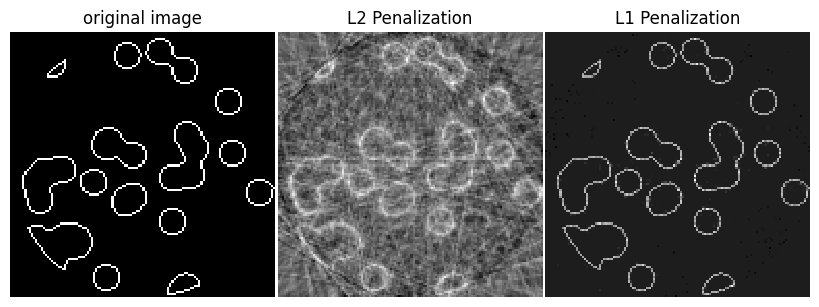

In [6]:
def _weights(x ,dx=1 ,orig=0):
  x = np.ravel(x)
  floor_x = np.floor((x - orig) / dx).astype(np.int64)
  alpha = (x - orig - floor_x * dx) / dx
  return np.hstack((floor_x ,floor_x + 1)),np.hstack((1 - alpha, alpha))  # np.hstack : Stack arrays in sequence horizontally (column wise).

def _generate_centre_coordinates(l_x):
  X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
  centre = l_x / 2.0
  X += 0.5 - centre
  Y += 0.5 - centre
  return X, Y

def build_projection_operator(l_x , n_dir):

  """Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
  X, Y = _generate_centre_coordinates(l_x)
  angles = np.linspace(0 ,np.pi ,n_dir , endpoint=False)
  data_inds, weights ,camera_inds = [] ,[],[]
  data_unravel_indices = np.arange(l_x**2)
  data_unravel_indices = np.hstack((data_unravel_indices , data_unravel_indices))

  for i ,angle in enumerate(angles):
    Xrot = np.cos(angle) * X - np.sin(angle) * Y
    inds , w = _weights(Xrot , dx = 1 ,orig = X.min())
    mask = np.logical_and(inds >= 0 ,inds < l_x )                       #numpy.logical_and : Compute the truth value of x1 AND x2 element-wise.
    weights += list(w[mask])
    camera_inds += list(inds[mask] + i * l_x)
    data_inds += list(data_unravel_indices[mask])

  proj_operator = sparse.coo_matrix((weights, (camera_inds , data_inds)))
  return proj_operator

def generate_synthetic_data():
  """Synthetic Binary Data """
  rs = np.random.RandomState(0)
  n_pts =36
  x,y = np.ogrid[0:l , 0:l]                                                   #np.ogrid : An instance which returns an open multi-dimensional “meshgrid”.
  mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0)**2 < (l / 2.0)**2
  mask = np.zeros((l ,l))
  points = l * rs.rand(2, n_pts)
  mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
  mask = ndimage.gaussian_filter(mask , sigma= l / n_pts)
  res = np.logical_and(mask > mask.mean(),mask_outer)                               #logical_and: Compute the truth value of x1 AND x2 element-wise.
  return np.logical_xor(res , ndimage.binary_erosion(res))

# Generate Synthetic Image and Projection

l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) Penalization

rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator , proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determine using cross validation with LassoCV

rgr_lasso = Lasso(alpha = 0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(data, cmap = plt.cm.gray , interpolation = 'nearest')
plt.axis("off")
plt.title("original image")
plt.subplot(132)
plt.imshow(rec_l2 , cmap= plt.cm.gray ,interpolation='nearest')
plt.title("L2 Penalization")
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1 ,cmap = plt.cm.grey , interpolation = 'nearest' )
plt.title('L1 Penalization')
plt.axis('off')

plt.subplots_adjust(hspace = 0.01 ,wspace = 0.01 , top=1 ,right=1 ,bottom =0 ,left=0)
plt.show()